1. обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10
2. оценить рост точности при увеличении ширины сети (больше фильтров)
3. оценить рост точности при увеличении глубины сети (больше слоев)
4. *сравнить с точностью полносвязной сети для этой выборки

In [1]:
import tensorflow as tf

# ограничение роста памяти
# иначе при запуске обучения происходит ошибка получения сверточного алгоритма
gpu_device = tf.config.experimental.list_physical_devices('GPU')
if gpu_device:
    tf.config.experimental.set_memory_growth(gpu_device[0], True)

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D

**Загрузка и подготовка данных**

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


X_train = X_train / 255
X_test = X_test / 255

X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [5]:
classes = [
    'самолет', 
    'автомобиль', 
    'птица', 
    'кот', 
    'олень', 
    'собака', 
    'лягушка', 
    'лошадь', 
    'корабль', 
    'грузовик'
]

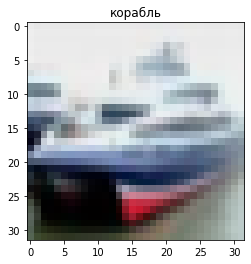

In [6]:
N = 1

plt.imshow(X_test[N])
plt.title(classes[np.argmax(y_test[N, :])])
plt.show()

In [7]:
datagen = ImageDataGenerator()

train_gen = datagen.flow(X_train, 
                         y_train,
                         batch_size=256)

**1. обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10**

In [8]:
def conv_unit(n_filters, prev_unit, dropout=0, random_state=None):
    '''
    Сверточный блок:
    2 сверточных слоя (3, 3) с ф-цией активации 'relu'
    
    '''
    tf.random.set_seed(random_state)
    u = Conv2D(n_filters, (3, 3), padding='same')(prev_unit)
    u = Activation('relu')(u)
    u = Conv2D(n_filters, (3, 3))(u)
    u = Activation('relu')(u)
    u = MaxPooling2D(pool_size=(2, 2))(u)
    u = Dropout(dropout)(u)
    return u


def fully_conn_unit(n_filters, prev_unit, n_layers=1, dropout=0, random_state=None):
    '''
    Полносвязный блок.
    
    '''
    tf.random.set_seed(random_state)
    u = Flatten()(prev_unit)
    for _ in range(n_layers):
        u = Dense(n_filters)(u)
        u = Activation('relu')(u)
    u = Dropout(dropout)(u)
    return u


def output_unit(n_filters, prev_unit, activation='softmax', random_state=None):
    tf.random.set_seed(random_state)
    u = Flatten()(prev_unit)
    u = Dense(n_filters, activation=activation)(u)
    return u

In [9]:
# результаты сохраним в словарь
results = {}

Базовая модель

In [10]:
seed = 1

inputs = Input(shape=X_train.shape[1:])

# 2 блока свертки ((32, 32), (64, 64))
unit = conv_unit(32, inputs, dropout=0.25, random_state=seed)
unit = conv_unit(64, unit, dropout=0.25, random_state=seed)

# полносвязный блок 128 фильтров
unit = fully_conn_unit(128, unit, dropout=0.5, random_state=seed)

# выходной слой
outputs = output_unit(10, unit, random_state=seed)

model = Model(inputs, outputs)
model.summary()
# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0     

In [11]:
train_eval = model.evaluate(X_train, y_train)[1:]
valid_eval = model.evaluate(X_test, y_test)[1:]

history = model.fit(train_gen, 
                    epochs=25, 
                    validation_data=(X_test, y_test)
                   )

results[('conv (32, 64), (128)', 'train')] = train_eval + history.history['accuracy']
results[('conv (32, 64), (128)', 'valid')] = valid_eval + history.history['val_accuracy']

313/313 [==============================] - 1s 4ms/step - loss: 2.3048 - accuracy: 0.0935
Epoch 1/25
196/196 [==============================] - 7s 35ms/step - loss: 1.8261 - accuracy: 0.3258 - val_loss: 1.4437 - val_accuracy: 0.4749
Epoch 2/25
196/196 [==============================] - 7s 34ms/step - loss: 1.4606 - accuracy: 0.4691 - val_loss: 1.2702 - val_accuracy: 0.5484
Epoch 3/25
196/196 [==============================] - 7s 35ms/step - loss: 1.3149 - accuracy: 0.5295 - val_loss: 1.1418 - val_accuracy: 0.5938
Epoch 4/25
196/196 [==============================] - 7s 36ms/step - loss: 1.2114 - accuracy: 0.5702 - val_loss: 1.0474 - val_accuracy: 0.6343
Epoch 5/25
196/196 [==============================] - 7s 35ms/step - loss: 1.1282 - accuracy: 0.6006 - val_loss: 0.9901 - val_accuracy: 0.6505
Epoch 6/25
196/196 [==============================] - 7s 34ms/step - loss: 1.0624 - accuracy: 0.6242 - val_loss: 0.9569 - val_accuracy: 0.6592
Epoch 7/25
196/196 [==============================] -

In [13]:
pd.DataFrame(results)

conv (32, 64), (128)        
                  train   valid
0               0.09328  0.0935
1               0.32582  0.4749
2               0.46912  0.5484
3               0.52952  0.5938
4               0.57020  0.6343
5               0.60062  0.6505
6               0.62420  0.6592
7               0.64240  0.6911
8               0.66030  0.6997
9               0.67422  0.7167
10              0.68728  0.7243
11              0.69778  0.7394
12              0.70606  0.7369
13              0.71258  0.7310
14              0.72324  0.7473
15              0.72594  0.7548
16              0.73696  0.7570
17              0.73988  0.7610
18              0.74770  0.7573
19              0.75110  0.7760
20              0.75416  0.7669
21              0.76136  0.7816
22              0.76528  0.7785
23              0.76918  0.7779
24              0.77032  0.7785
25              0.77856  0.7813

**2. оценить рост точности при увеличении ширины сети (больше фильтров)**

In [14]:
seed = 1

inputs = Input(shape=X_train.shape[1:])

# 2 блока свертки ((64, 64), (128, 128))
unit = conv_unit(64, inputs, dropout=0.25, random_state=seed)
unit = conv_unit(128, unit, dropout=0.25, random_state=seed)

# полносвязный блок (256)
unit = fully_conn_unit(256, unit, dropout=0.5, random_state=seed)

# выходной слой 
outputs = output_unit(10, unit, random_state=seed)

model = Model(inputs, outputs)
model.summary()
# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 64)        0   

In [15]:
train_eval = model.evaluate(X_train, y_train)[1:]
valid_eval = model.evaluate(X_test, y_test)[1:]

history = model.fit(train_gen, 
                    epochs=25, 
                    validation_data=(X_test, y_test)
                   )

results[('conv (64, 128), (256)', 'train')] = train_eval + history.history['accuracy']
results[('conv (64, 128), (256)', 'valid')] = valid_eval + history.history['val_accuracy']

313/313 [==============================] - 2s 5ms/step - loss: 2.3043 - accuracy: 0.0979
Epoch 1/25
196/196 [==============================] - 14s 72ms/step - loss: 1.7318 - accuracy: 0.3624 - val_loss: 1.3695 - val_accuracy: 0.4955
Epoch 2/25
196/196 [==============================] - 14s 71ms/step - loss: 1.2931 - accuracy: 0.5375 - val_loss: 1.1797 - val_accuracy: 0.5745
Epoch 3/25
196/196 [==============================] - 14s 71ms/step - loss: 1.1035 - accuracy: 0.6107 - val_loss: 0.9592 - val_accuracy: 0.6594
Epoch 4/25
196/196 [==============================] - 14s 71ms/step - loss: 0.9612 - accuracy: 0.6611 - val_loss: 0.8229 - val_accuracy: 0.7081
Epoch 5/25
196/196 [==============================] - 14s 71ms/step - loss: 0.8570 - accuracy: 0.7003 - val_loss: 0.7934 - val_accuracy: 0.7197
Epoch 6/25
196/196 [==============================] - 14s 71ms/step - loss: 0.7926 - accuracy: 0.7227 - val_loss: 0.7367 - val_accuracy: 0.7434
Epoch 7/25
196/196 [===========================

In [16]:
pd.DataFrame(results)

conv (32, 64), (128)         conv (64, 128), (256)        
                  train   valid                 train   valid
0               0.09328  0.0935               0.09642  0.0979
1               0.32582  0.4749               0.36238  0.4955
2               0.46912  0.5484               0.53750  0.5745
3               0.52952  0.5938               0.61072  0.6594
4               0.57020  0.6343               0.66106  0.7081
5               0.60062  0.6505               0.70028  0.7197
6               0.62420  0.6592               0.72268  0.7434
7               0.64240  0.6911               0.74124  0.7596
8               0.66030  0.6997               0.75726  0.7612
9               0.67422  0.7167               0.77328  0.7737
10              0.68728  0.7243               0.78362  0.7801
11              0.69778  0.7394               0.79712  0.7821
12              0.70606  0.7369               0.80660  0.7885
13              0.71258  0.7310               0.81018  0.7921
14              0.72324  0.7473               0.82124  0.7978
15              0.72594  0.7548               0.83052  0.7945
16              0.73696  0.7570               0.83324  0.7970
17              0.73988  0.7610               0.84208  0.8029
18              0.74770  0.7573               0.84266  0.8025
19              0.75110  0.7760               0.84994  0.8053
20              0.75416  0.7669               0.85568  0.8069
21              0.76136  0.7816               0.86070  0.8011
22              0.76528  0.7785               0.86166  0.8056
23              0.76918  0.7779               0.86968  0.8065
24              0.77032  0.7785               0.87368  0.8088
25              0.77856  0.7813               0.87818  0.8103

In [17]:
seed = 1

inputs = Input(shape=X_train.shape[1:])

# 2 блока свертки ((128, 128), (256, 256))
unit = conv_unit(128, inputs, dropout=0.25, random_state=seed)
unit = conv_unit(256, unit, dropout=0.25, random_state=seed)

# полносвязный блок (512)
unit = fully_conn_unit(512, unit, dropout=0.5, random_state=seed)

# выходной слой 
outputs = output_unit(10, unit, random_state=seed)

model = Model(inputs, outputs)
model.summary()
# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
activation_11 (Activation)   (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 128)       0   

In [18]:
train_eval = model.evaluate(X_train, y_train)[1:]
valid_eval = model.evaluate(X_test, y_test)[1:]

history = model.fit(train_gen, 
                    epochs=25, 
                    validation_data=(X_test, y_test)
                   )

results[('conv (128, 256), (512)', 'train')] = train_eval + history.history['accuracy']
results[('conv (128, 256), (512)', 'valid')] = valid_eval + history.history['val_accuracy']

313/313 [==============================] - 3s 10ms/step - loss: 2.3047 - accuracy: 0.0990
Epoch 1/25
196/196 [==============================] - 32s 161ms/step - loss: 1.7385 - accuracy: 0.3606 - val_loss: 1.3078 - val_accuracy: 0.5335
Epoch 2/25
196/196 [==============================] - 31s 158ms/step - loss: 1.2234 - accuracy: 0.5632 - val_loss: 1.0071 - val_accuracy: 0.6423
Epoch 3/25
196/196 [==============================] - 31s 158ms/step - loss: 1.0146 - accuracy: 0.6411 - val_loss: 0.9580 - val_accuracy: 0.6554
Epoch 4/25
196/196 [==============================] - 31s 158ms/step - loss: 0.8768 - accuracy: 0.6914 - val_loss: 0.7842 - val_accuracy: 0.7260
Epoch 5/25
196/196 [==============================] - 31s 160ms/step - loss: 0.7744 - accuracy: 0.7297 - val_loss: 0.7272 - val_accuracy: 0.7429
Epoch 6/25
196/196 [==============================] - 32s 162ms/step - loss: 0.7115 - accuracy: 0.7512 - val_loss: 0.6773 - val_accuracy: 0.7685
Epoch 7/25
196/196 [====================

In [19]:
pd.DataFrame(results)

conv (32, 64), (128)         conv (64, 128), (256)          \
                  train   valid                 train   valid   
0               0.09328  0.0935               0.09642  0.0979   
1               0.32582  0.4749               0.36238  0.4955   
2               0.46912  0.5484               0.53750  0.5745   
3               0.52952  0.5938               0.61072  0.6594   
4               0.57020  0.6343               0.66106  0.7081   
5               0.60062  0.6505               0.70028  0.7197   
6               0.62420  0.6592               0.72268  0.7434   
7               0.64240  0.6911               0.74124  0.7596   
8               0.66030  0.6997               0.75726  0.7612   
9               0.67422  0.7167               0.77328  0.7737   
10              0.68728  0.7243               0.78362  0.7801   
11              0.69778  0.7394               0.79712  0.7821   
12              0.70606  0.7369               0.80660  0.7885   
13              0.71258  0.7310               0.81018  0.7921   
14              0.72324  0.7473               0.82124  0.7978   
15              0.72594  0.7548               0.83052  0.7945   
16              0.73696  0.7570               0.83324  0.7970   
17              0.73988  0.7610               0.84208  0.8029   
18              0.74770  0.7573               0.84266  0.8025   
19              0.75110  0.7760               0.84994  0.8053   
20              0.75416  0.7669               0.85568  0.8069   
21              0.76136  0.7816               0.86070  0.8011   
22              0.76528  0.7785               0.86166  0.8056   
23              0.76918  0.7779               0.86968  0.8065   
24              0.77032  0.7785               0.87368  0.8088   
25              0.77856  0.7813               0.87818  0.8103   

   conv (128, 256), (512)          
                    train   valid  
0                 0.09824  0.0990  
1                 0.36064  0.5335  
2                 0.56322  0.6423  
3                 0.64112  0.6554  
4                 0.69138  0.7260  
5                 0.72968  0.7429  
6                 0.75116  0.7685  
7                 0.77286  0.7628  
8                 0.79140  0.7871  
9                 0.80526  0.7931  
10                0.82048  0.7840  
11                0.83240  0.7997  
12                0.83898  0.7957  
13                0.85086  0.8043  
14                0.85830  0.8041  
15                0.86716  0.8067  
16                0.87416  0.8009  
17                0.88236  0.8135  
18                0.88746  0.8100  
19                0.89304  0.8146  
20                0.89686  0.8169  
21                0.90276  0.8134  
22                0.90694  0.8121  
23                0.91244  0.8185  
24                0.91208  0.8156  
25                0.91610  0.8206

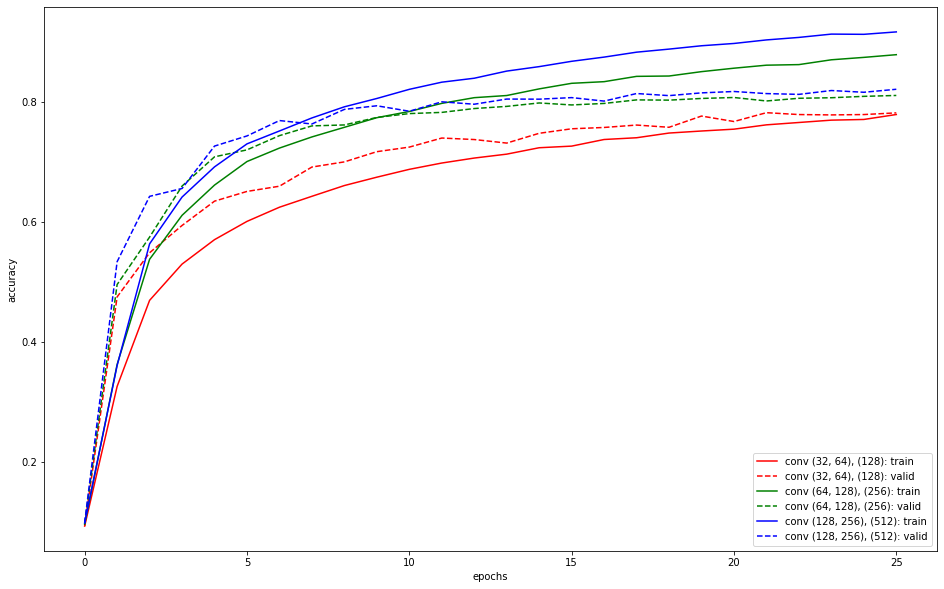

In [20]:
names_colors = {
    'conv (32, 64), (128)': 'r', 
    'conv (64, 128), (256)': 'g', 
    'conv (128, 256), (512)': 'b'
}

plt.figure(figsize=(16, 10))
for name, color in names_colors.items():
    acc_train = results[(name, 'train')]
    acc_valid = results[(name, 'valid')]
    plt.plot(range(len(acc_train)), acc_train, label=f'{name}: train', c=color, linestyle='-')
    plt.plot(range(len(acc_valid)), acc_valid, label=f'{name}: valid', c=color, linestyle='--')
    
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.show()

Увеличением количества фильтров удается повысить метрики как на тренировочной, так и на валидационной выборках. Модели обучаются быстрее. Однако начинает выражаться переобучение.

**3. оценить рост точности при увеличении глубины сети (больше слоев)**

In [21]:
seed = 1

inputs = Input(shape=X_train.shape[1:])

# 3 блока свертки (32, 64, 128)
unit = conv_unit(32, inputs, dropout=0.25, random_state=seed)
unit = conv_unit(64, unit, dropout=0.25, random_state=seed)
unit = conv_unit(128, unit, dropout=0.25, random_state=seed)

# полносвязный блок (128)
unit = fully_conn_unit(128, unit, dropout=0.5, random_state=seed)

# выходной слой
outputs = output_unit(10, unit, random_state=seed)

model = Model(inputs, outputs)
model.summary()
# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 15, 32)        0   

In [22]:
train_eval = model.evaluate(X_train, y_train)[1:]
valid_eval = model.evaluate(X_test, y_test)[1:]

history = model.fit(train_gen, 
                    epochs=25, 
                    validation_data=(X_test, y_test)
                   )

results[('conv (32, 64, 128), (128)', 'train')] = train_eval + history.history['accuracy']
results[('conv (32, 64, 128), (128)', 'valid')] = valid_eval + history.history['val_accuracy']

313/313 [==============================] - 1s 4ms/step - loss: 2.3039 - accuracy: 0.1009
Epoch 1/25
196/196 [==============================] - 8s 39ms/step - loss: 1.9282 - accuracy: 0.2685 - val_loss: 1.5708 - val_accuracy: 0.4193
Epoch 2/25
196/196 [==============================] - 7s 38ms/step - loss: 1.4914 - accuracy: 0.4529 - val_loss: 1.3181 - val_accuracy: 0.5222
Epoch 3/25
196/196 [==============================] - 7s 38ms/step - loss: 1.3055 - accuracy: 0.5293 - val_loss: 1.1505 - val_accuracy: 0.5927
Epoch 4/25
196/196 [==============================] - 7s 38ms/step - loss: 1.1580 - accuracy: 0.5875 - val_loss: 1.1277 - val_accuracy: 0.5931
Epoch 5/25
196/196 [==============================] - 7s 38ms/step - loss: 1.0586 - accuracy: 0.6280 - val_loss: 0.9114 - val_accuracy: 0.6788
Epoch 6/25
196/196 [==============================] - 7s 38ms/step - loss: 0.9839 - accuracy: 0.6549 - val_loss: 0.8902 - val_accuracy: 0.6854
Epoch 7/25
196/196 [==============================] -

In [24]:
pd.DataFrame(results)

conv (32, 64), (128)         conv (64, 128), (256)          \
                  train   valid                 train   valid   
0               0.09328  0.0935               0.09642  0.0979   
1               0.32582  0.4749               0.36238  0.4955   
2               0.46912  0.5484               0.53750  0.5745   
3               0.52952  0.5938               0.61072  0.6594   
4               0.57020  0.6343               0.66106  0.7081   
5               0.60062  0.6505               0.70028  0.7197   
6               0.62420  0.6592               0.72268  0.7434   
7               0.64240  0.6911               0.74124  0.7596   
8               0.66030  0.6997               0.75726  0.7612   
9               0.67422  0.7167               0.77328  0.7737   
10              0.68728  0.7243               0.78362  0.7801   
11              0.69778  0.7394               0.79712  0.7821   
12              0.70606  0.7369               0.80660  0.7885   
13              0.71258  0.7310               0.81018  0.7921   
14              0.72324  0.7473               0.82124  0.7978   
15              0.72594  0.7548               0.83052  0.7945   
16              0.73696  0.7570               0.83324  0.7970   
17              0.73988  0.7610               0.84208  0.8029   
18              0.74770  0.7573               0.84266  0.8025   
19              0.75110  0.7760               0.84994  0.8053   
20              0.75416  0.7669               0.85568  0.8069   
21              0.76136  0.7816               0.86070  0.8011   
22              0.76528  0.7785               0.86166  0.8056   
23              0.76918  0.7779               0.86968  0.8065   
24              0.77032  0.7785               0.87368  0.8088   
25              0.77856  0.7813               0.87818  0.8103   

   conv (128, 256), (512)         conv (32, 64, 128), (128)          
                    train   valid                     train   valid  
0                 0.09824  0.0990                   0.10016  0.1009  
1                 0.36064  0.5335                   0.26846  0.4193  
2                 0.56322  0.6423                   0.45286  0.5222  
3                 0.64112  0.6554                   0.52928  0.5927  
4                 0.69138  0.7260                   0.58748  0.5931  
5                 0.72968  0.7429                   0.62804  0.6788  
6                 0.75116  0.7685                   0.65490  0.6854  
7                 0.77286  0.7628                   0.68174  0.7077  
8                 0.79140  0.7871                   0.70150  0.7390  
9                 0.80526  0.7931                   0.71612  0.7488  
10                0.82048  0.7840                   0.73502  0.7657  
11                0.83240  0.7997                   0.74854  0.7684  
12                0.83898  0.7957                   0.75942  0.7623  
13                0.85086  0.8043                   0.76776  0.7793  
14                0.85830  0.8041                   0.77904  0.7922  
15                0.86716  0.8067                   0.78384  0.7870  
16                0.87416  0.8009                   0.79242  0.7989  
17                0.88236  0.8135                   0.79896  0.7977  
18                0.88746  0.8100                   0.80410  0.7970  
19                0.89304  0.8146                   0.80798  0.8046  
20                0.89686  0.8169                   0.81012  0.8002  
21                0.90276  0.8134                   0.82262  0.8046  
22                0.90694  0.8121                   0.82474  0.8055  
23                0.91244  0.8185                   0.82966  0.8112  
24                0.91208  0.8156                   0.83148  0.8022  
25                0.91610  0.8206                   0.83540  0.8134

In [25]:
seed = 1

inputs = Input(shape=X_train.shape[1:])

# 3 блока свертки (32, 64, 128)
unit = conv_unit(32, inputs, dropout=0.25, random_state=seed)
unit = conv_unit(64, unit, dropout=0.25, random_state=seed)
unit = conv_unit(128, unit, dropout=0.25, random_state=seed)

# полносвязный блок 2 слоя (128)
unit = fully_conn_unit(128, unit, n_layers=2, dropout=0.5, random_state=seed)

# выходной слой
outputs = output_unit(10, unit, random_state=seed)

model = Model(inputs, outputs)
model.summary()
# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_23 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 15, 32)        0   

In [26]:
train_eval = model.evaluate(X_train, y_train)[1:]
valid_eval = model.evaluate(X_test, y_test)[1:]

history = model.fit(train_gen, 
                    epochs=25, 
                    validation_data=(X_test, y_test)
                   )

results[('conv (32, 64, 128), (128, 128)', 'train')] = train_eval + history.history['accuracy']
results[('conv (32, 64, 128), (128, 128)', 'valid')] = valid_eval + history.history['val_accuracy']

313/313 [==============================] - 1s 4ms/step - loss: 2.3025 - accuracy: 0.0985
Epoch 1/25
196/196 [==============================] - 7s 38ms/step - loss: 1.9563 - accuracy: 0.2552 - val_loss: 1.6340 - val_accuracy: 0.3875
Epoch 2/25
196/196 [==============================] - 7s 38ms/step - loss: 1.5347 - accuracy: 0.4322 - val_loss: 1.3235 - val_accuracy: 0.5234
Epoch 3/25
196/196 [==============================] - 8s 39ms/step - loss: 1.3199 - accuracy: 0.5264 - val_loss: 1.1457 - val_accuracy: 0.5910
Epoch 4/25
196/196 [==============================] - 8s 39ms/step - loss: 1.1803 - accuracy: 0.5793 - val_loss: 1.0543 - val_accuracy: 0.6244
Epoch 5/25
196/196 [==============================] - 8s 39ms/step - loss: 1.0850 - accuracy: 0.6152 - val_loss: 0.9691 - val_accuracy: 0.6558
Epoch 6/25
196/196 [==============================] - 8s 39ms/step - loss: 1.0083 - accuracy: 0.6474 - val_loss: 0.9066 - val_accuracy: 0.6817
Epoch 7/25
196/196 [==============================] -

In [27]:
pd.DataFrame(results)

conv (32, 64), (128)         conv (64, 128), (256)          \
                  train   valid                 train   valid   
0               0.09328  0.0935               0.09642  0.0979   
1               0.32582  0.4749               0.36238  0.4955   
2               0.46912  0.5484               0.53750  0.5745   
3               0.52952  0.5938               0.61072  0.6594   
4               0.57020  0.6343               0.66106  0.7081   
5               0.60062  0.6505               0.70028  0.7197   
6               0.62420  0.6592               0.72268  0.7434   
7               0.64240  0.6911               0.74124  0.7596   
8               0.66030  0.6997               0.75726  0.7612   
9               0.67422  0.7167               0.77328  0.7737   
10              0.68728  0.7243               0.78362  0.7801   
11              0.69778  0.7394               0.79712  0.7821   
12              0.70606  0.7369               0.80660  0.7885   
13              0.71258  0.7310               0.81018  0.7921   
14              0.72324  0.7473               0.82124  0.7978   
15              0.72594  0.7548               0.83052  0.7945   
16              0.73696  0.7570               0.83324  0.7970   
17              0.73988  0.7610               0.84208  0.8029   
18              0.74770  0.7573               0.84266  0.8025   
19              0.75110  0.7760               0.84994  0.8053   
20              0.75416  0.7669               0.85568  0.8069   
21              0.76136  0.7816               0.86070  0.8011   
22              0.76528  0.7785               0.86166  0.8056   
23              0.76918  0.7779               0.86968  0.8065   
24              0.77032  0.7785               0.87368  0.8088   
25              0.77856  0.7813               0.87818  0.8103   

   conv (128, 256), (512)         conv (32, 64, 128), (128)          \
                    train   valid                     train   valid   
0                 0.09824  0.0990                   0.10016  0.1009   
1                 0.36064  0.5335                   0.26846  0.4193   
2                 0.56322  0.6423                   0.45286  0.5222   
3                 0.64112  0.6554                   0.52928  0.5927   
4                 0.69138  0.7260                   0.58748  0.5931   
5                 0.72968  0.7429                   0.62804  0.6788   
6                 0.75116  0.7685                   0.65490  0.6854   
7                 0.77286  0.7628                   0.68174  0.7077   
8                 0.79140  0.7871                   0.70150  0.7390   
9                 0.80526  0.7931                   0.71612  0.7488   
10                0.82048  0.7840                   0.73502  0.7657   
11                0.83240  0.7997                   0.74854  0.7684   
12                0.83898  0.7957                   0.75942  0.7623   
13                0.85086  0.8043                   0.76776  0.7793   
14                0.85830  0.8041                   0.77904  0.7922   
15                0.86716  0.8067                   0.78384  0.7870   
16                0.87416  0.8009                   0.79242  0.7989   
17                0.88236  0.8135                   0.79896  0.7977   
18                0.88746  0.8100                   0.80410  0.7970   
19                0.89304  0.8146                   0.80798  0.8046   
20                0.89686  0.8169                   0.81012  0.8002   
21                0.90276  0.8134                   0.82262  0.8046   
22                0.90694  0.8121                   0.82474  0.8055   
23                0.91244  0.8185                   0.82966  0.8112   
24                0.91208  0.8156                   0.83148  0.8022   
25                0.91610  0.8206                   0.83540  0.8134   

   conv (32, 64, 128), (128, 128)          
                            train   valid  
0                         0.09866  0.0985  
1                         0.25524  0.3875  
2                

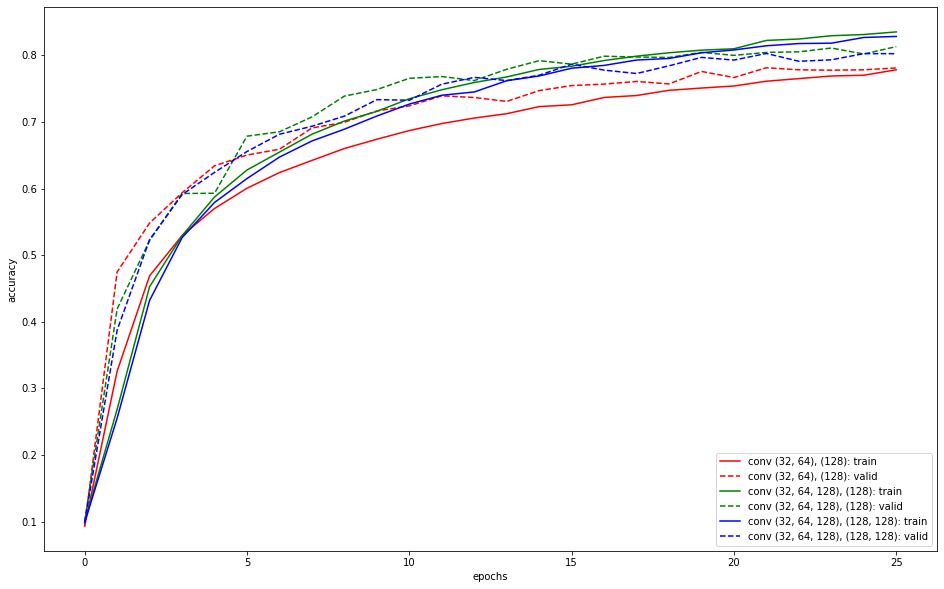

In [28]:
names_colors = {
    'conv (32, 64), (128)': 'r', 
    'conv (32, 64, 128), (128)': 'g', 
    'conv (32, 64, 128), (128, 128)': 'b'
}

plt.figure(figsize=(16, 10))
for name, color in names_colors.items():
    acc_train = results[(name, 'train')]
    acc_valid = results[(name, 'valid')]
    plt.plot(range(len(acc_train)), acc_train, label=f'{name}: train', c=color, linestyle='-')
    plt.plot(range(len(acc_valid)), acc_valid, label=f'{name}: valid', c=color, linestyle='--')
    
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.show()

При увеличении количества сверточных слоев (с 4 до 6) отмечается рост метрики. Меньше выражается переобучение в сравнении с моделями, у которых количество слоев такое же, как у базовой модели, а фильтров больше.

При увеличении количества полносвязных слоев не похоже, что оказывается какое-то влияние на результат

**4. *сравнить с точностью полносвязной сети для этой выборки**

In [39]:
seed = 1

inputs = Input(shape=X_train.shape[1:])

# 3 полносвязных блока по 2 слоя ((512, 512), (256, 256), (128, 128))
unit = fully_conn_unit(512, inputs, n_layers=2, dropout=0.25, random_state=seed)
unit = fully_conn_unit(256, unit, n_layers=2, dropout=0.25, random_state=seed)
unit = fully_conn_unit(128, unit, n_layers=2, dropout=0.25, random_state=seed)

# выходной слой
outputs = output_unit(10, unit, random_state=seed)

model = Model(inputs, outputs)
model.summary()
# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               1573376   
_________________________________________________________________
activation_48 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_49 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0   

In [40]:
train_eval = model.evaluate(X_train, y_train)[1:]
valid_eval = model.evaluate(X_test, y_test)[1:]

history = model.fit(train_gen, 
                    epochs=25, 
                    validation_data=(X_test, y_test)
                   )

results[('fully_connected', 'train')] = train_eval + history.history['accuracy']
results[('fully_connected', 'valid')] = valid_eval + history.history['val_accuracy']

313/313 [==============================] - 1s 3ms/step - loss: 2.3122 - accuracy: 0.1042
Epoch 1/25
196/196 [==============================] - 3s 15ms/step - loss: 2.0604 - accuracy: 0.2242 - val_loss: 1.8671 - val_accuracy: 0.3246
Epoch 2/25
196/196 [==============================] - 3s 15ms/step - loss: 1.8343 - accuracy: 0.3365 - val_loss: 1.7386 - val_accuracy: 0.3733
Epoch 3/25
196/196 [==============================] - 3s 15ms/step - loss: 1.7453 - accuracy: 0.3706 - val_loss: 1.6498 - val_accuracy: 0.4064
Epoch 4/25
196/196 [==============================] - 3s 15ms/step - loss: 1.6780 - accuracy: 0.3971 - val_loss: 1.6206 - val_accuracy: 0.4186
Epoch 5/25
196/196 [==============================] - 3s 15ms/step - loss: 1.6243 - accuracy: 0.4192 - val_loss: 1.5453 - val_accuracy: 0.4486
Epoch 6/25
196/196 [==============================] - 3s 15ms/step - loss: 1.5783 - accuracy: 0.4352 - val_loss: 1.5368 - val_accuracy: 0.4494
Epoch 7/25
196/196 [==============================] -

In [41]:
pd.DataFrame(results)

conv (32, 64), (128)         conv (64, 128), (256)          \
                  train   valid                 train   valid   
0               0.09328  0.0935               0.09642  0.0979   
1               0.32582  0.4749               0.36238  0.4955   
2               0.46912  0.5484               0.53750  0.5745   
3               0.52952  0.5938               0.61072  0.6594   
4               0.57020  0.6343               0.66106  0.7081   
5               0.60062  0.6505               0.70028  0.7197   
6               0.62420  0.6592               0.72268  0.7434   
7               0.64240  0.6911               0.74124  0.7596   
8               0.66030  0.6997               0.75726  0.7612   
9               0.67422  0.7167               0.77328  0.7737   
10              0.68728  0.7243               0.78362  0.7801   
11              0.69778  0.7394               0.79712  0.7821   
12              0.70606  0.7369               0.80660  0.7885   
13              0.71258  0.7310               0.81018  0.7921   
14              0.72324  0.7473               0.82124  0.7978   
15              0.72594  0.7548               0.83052  0.7945   
16              0.73696  0.7570               0.83324  0.7970   
17              0.73988  0.7610               0.84208  0.8029   
18              0.74770  0.7573               0.84266  0.8025   
19              0.75110  0.7760               0.84994  0.8053   
20              0.75416  0.7669               0.85568  0.8069   
21              0.76136  0.7816               0.86070  0.8011   
22              0.76528  0.7785               0.86166  0.8056   
23              0.76918  0.7779               0.86968  0.8065   
24              0.77032  0.7785               0.87368  0.8088   
25              0.77856  0.7813               0.87818  0.8103   

   conv (128, 256), (512)         conv (32, 64, 128), (128)          \
                    train   valid                     train   valid   
0                 0.09824  0.0990                   0.10016  0.1009   
1                 0.36064  0.5335                   0.26846  0.4193   
2                 0.56322  0.6423                   0.45286  0.5222   
3                 0.64112  0.6554                   0.52928  0.5927   
4                 0.69138  0.7260                   0.58748  0.5931   
5                 0.72968  0.7429                   0.62804  0.6788   
6                 0.75116  0.7685                   0.65490  0.6854   
7                 0.77286  0.7628                   0.68174  0.7077   
8                 0.79140  0.7871                   0.70150  0.7390   
9                 0.80526  0.7931                   0.71612  0.7488   
10                0.82048  0.7840                   0.73502  0.7657   
11                0.83240  0.7997                   0.74854  0.7684   
12                0.83898  0.7957                   0.75942  0.7623   
13                0.85086  0.8043                   0.76776  0.7793   
14                0.85830  0.8041                   0.77904  0.7922   
15                0.86716  0.8067                   0.78384  0.7870   
16                0.87416  0.8009                   0.79242  0.7989   
17                0.88236  0.8135                   0.79896  0.7977   
18                0.88746  0.8100                   0.80410  0.7970   
19                0.89304  0.8146                   0.80798  0.8046   
20                0.89686  0.8169                   0.81012  0.8002   
21                0.90276  0.8134                   0.82262  0.8046   
22                0.90694  0.8121                   0.82474  0.8055   
23                0.91244  0.8185                   0.82966  0.8112   
24                0.91208  0.8156                   0.83148  0.8022   
25                0.91610  0.8206                   0.83540  0.8134   

   conv (32, 64, 128), (128, 128)         fully_connected          
                            train   valid           train   valid  
0                         0.09866  0.0985         0.10188

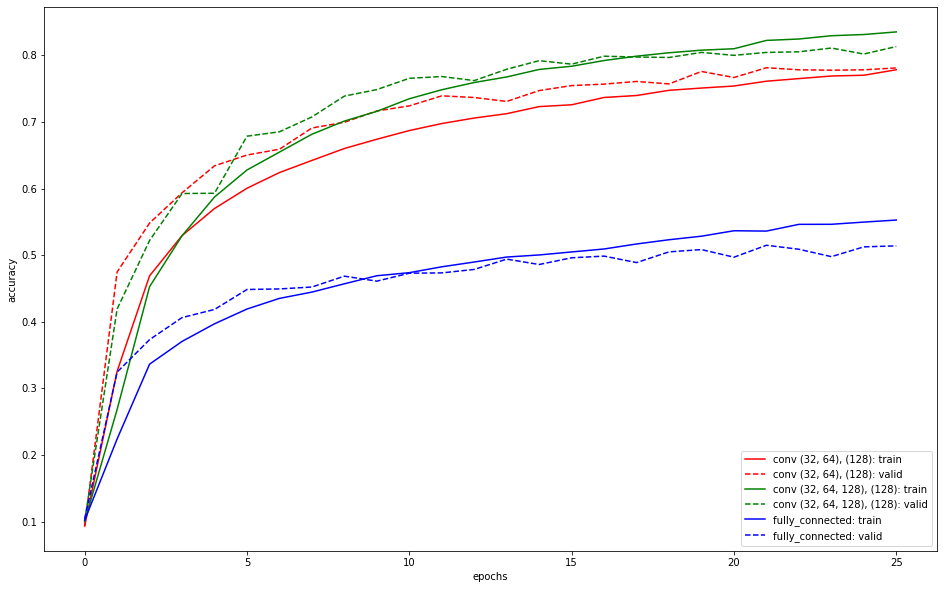

In [42]:
names_colors = {
    'conv (32, 64), (128)': 'r', 
    'conv (32, 64, 128), (128)': 'g', 
    'fully_connected': 'b'
}

plt.figure(figsize=(16, 10))
for name, color in names_colors.items():
    acc_train = results[(name, 'train')]
    acc_valid = results[(name, 'valid')]
    plt.plot(range(len(acc_train)), acc_train, label=f'{name}: train', c=color, linestyle='-')
    plt.plot(range(len(acc_valid)), acc_valid, label=f'{name}: valid', c=color, linestyle='--')
    
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.show()

Полносвязная сеть показала наихудший результат.

**Выводы:**

* Сверточные сети показывают результат значительно лучший, в сравнении с полносвязными;
* Увеличение количества фильтров в слоях увеличить скорость обучения, но вместе с тем вырастает степень переобученности моделей; 
* Увеличение количества сверточных слоев в модели позволяет улучшить результат, без сильного переобучения. В целом улучшается обобщающая способность модели.